# PARTE_3_CLASIFICACIONES

# Carga de datos y librerias

In [1]:
!pip install wordcloud
!pip install spacy
!python -m spacy download es_core_news_sm

2024-01-19 17:25:25.655015: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-01-19 17:25:25.655166: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-01-19 17:25:25.658190: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-01-19 17:25:25.675120: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-01-19 17:25:27.905307: W tensorflow/compiler/tf2

In [2]:
# Comenzamos importando las librerias que usaremos
import pandas as pd
import numpy as np
from wordcloud import WordCloud
import matplotlib.pyplot as plt
import plotly.express as px
import spacy
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report
from sklearn.metrics import confusion_matrix
from scipy.sparse import hstack
from sklearn.preprocessing import MinMaxScaler
import nltk
nltk.download('vader_lexicon')
from nltk.sentiment import SentimentIntensityAnalyzer
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, LSTM, Dense, Dropout
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import precision_score, recall_score, f1_score
from keras.layers import Input
from keras.layers import concatenate
from keras.models import Model

[nltk_data] Downloading package vader_lexicon to /root/nltk_data...
[nltk_data]   Package vader_lexicon is already up-to-date!


In [3]:
# Para trabajar con el archivo .csv creado en la anterior parte usamos el siguiente código

# Especificamos la ruta de tu archivo CSV
ruta_archivo_csv = '/content/df_poemas_final.csv'

# Cargamos el archivo CSV en un DataFrame
df = pd.read_csv(ruta_archivo_csv)

# Mostramos el DataFrame
df.head(5)

autor                        titulo  \
0  damaso alonso         a los que van a nacer   
1  damaso alonso   a un río le llamaban carlos   
2  damaso alonso  adiós al poeta rafael melero   
3  damaso alonso                          amor   
4  damaso alonso                         burla   

                                               poema  numero_total_estrofas  \
0  \n¡Cuán cerca todavía\nde las manos de Dios! ¿...                      4   
1  \nYo me senté en la orilla;\nquería preguntart...                      8   
2  \n        no hay que llorarte, melero.\n      ...                      5   
3  \n¡Primavera feroz! Va mi ternura\npor las más...                      4   
4  \npor las praderas hondas,\navizor y azoradas\...                      3   

            versos_por_estrofa  \
0               [12, 11, 7, 8]   
1  [4, 4, 8, 9, 10, 11, 7, 13]   
2              [6, 6, 6, 6, 1]   
3                 [4, 4, 3, 3]   
4                    [4, 4, 4]   

                       distribucion_silabas_estrofas  entropia_lexica_sust_adj  
0  {1: [6, 12, 11, 11, 12, 10, 13, 15, 9, 13, 13,...                  5.998270  
1  {1: [8, 14, 19, 25], 2: [15, 18, 4, 12], 3: [1...                  5.776153  
2  {1: [9, 9, 4, 9, 10, 5], 2: [9, 8, 5, 9, 10, 4...                  4.706891  
3  {1: [12, 11, 13, 12], 2: [14, 13, 12, 12], 3: ...                  5.072140  
4  {1: [8, 6, 6, 6], 2: [7, 8, 7, 8], 3: [7, 6, 6...                  4.368523

# Análisis de palabras clave




Realizamos un análisis de palabras clave para identificar las palabras más frecuentes en los poemas de cada autor. Luego, analizamos si la frecuencia de ciertas palabras se correlaciona con alguna otra variable. Usaremos dos enfoques para este cálculo:



*  Usando etiquetas POS
*  Usando un modelo de lenguaje preentrenado (en este caso spaCy)

POS - Enfoque usando el etiquetado gramatical de las palabras mediante el uso de un etiquetador POS (partes del discurso). Para ello debemos descargar el etiquetador POS en español.

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /root/nltk_data...
[nltk_data]   Package averaged_perceptron_tagger is already up-to-
[nltk_data]       date!
[nltk_data] Downloading package universal_tagset to /root/nltk_data...
[nltk_data]   Package universal_tagset is already up-to-date!


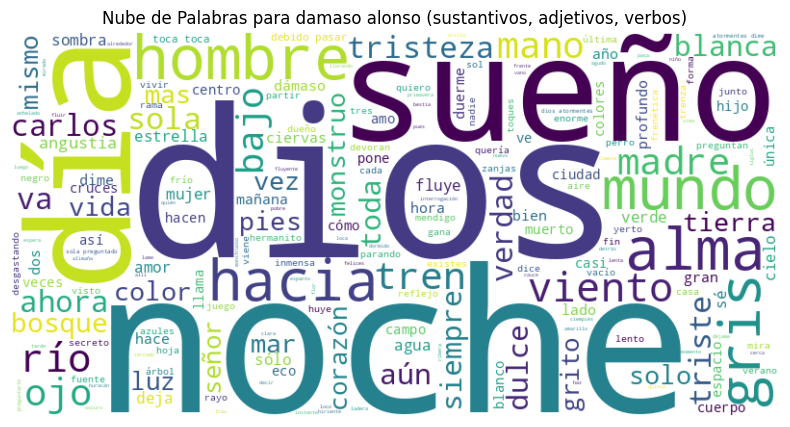

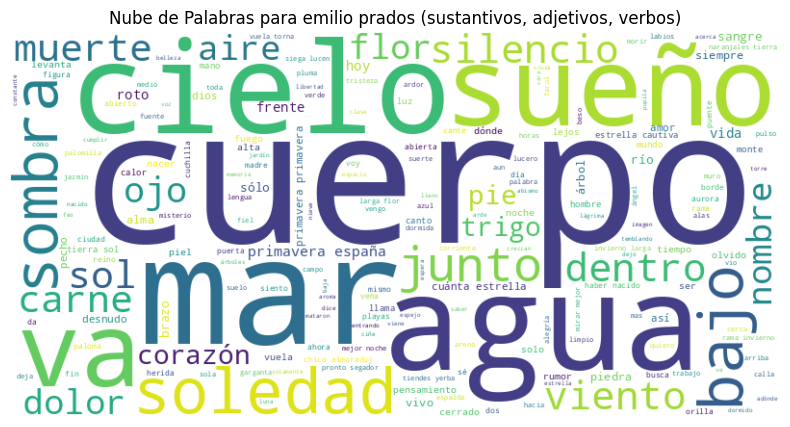

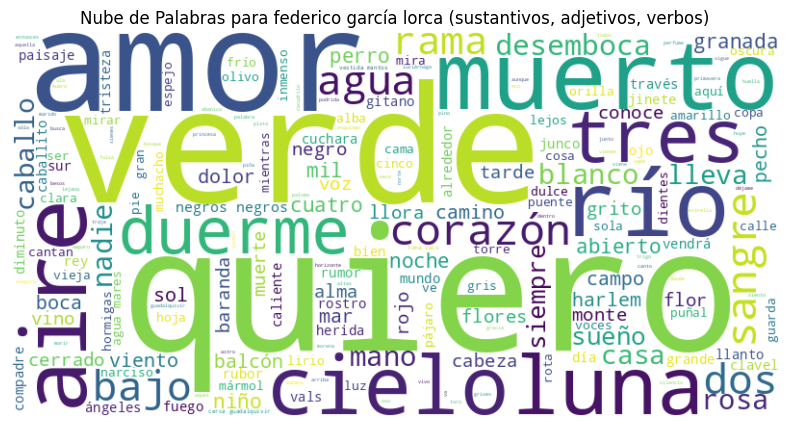

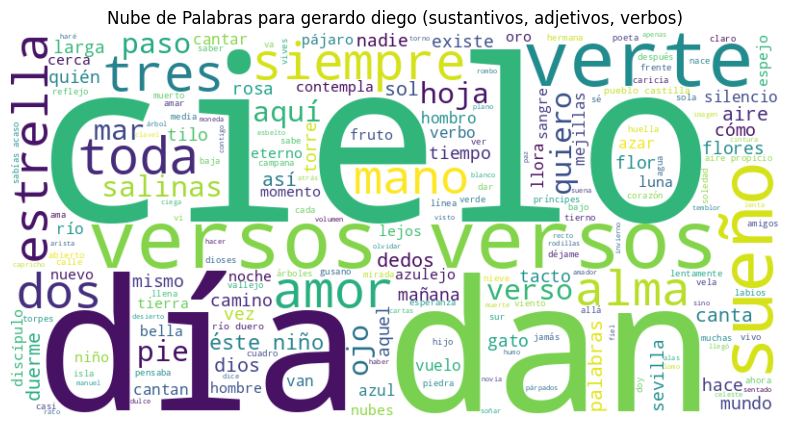

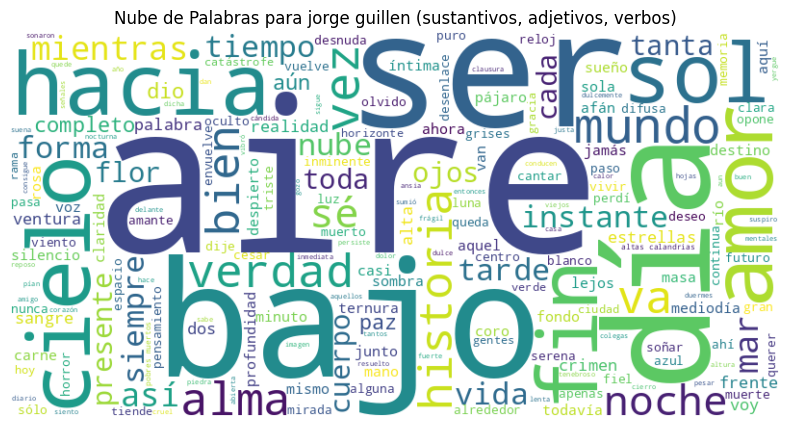

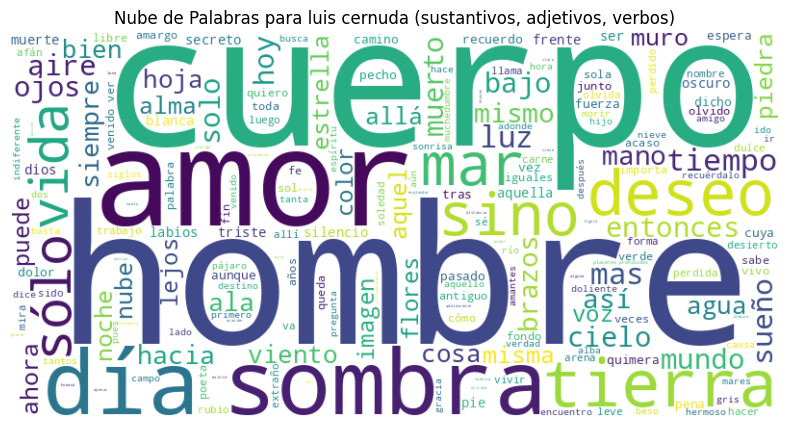

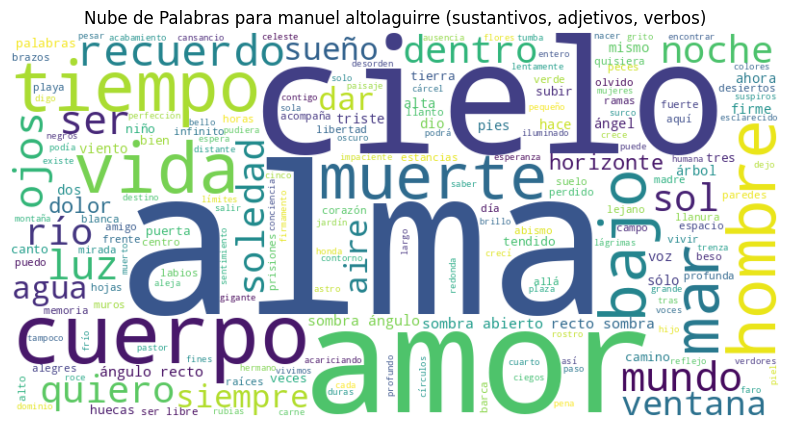

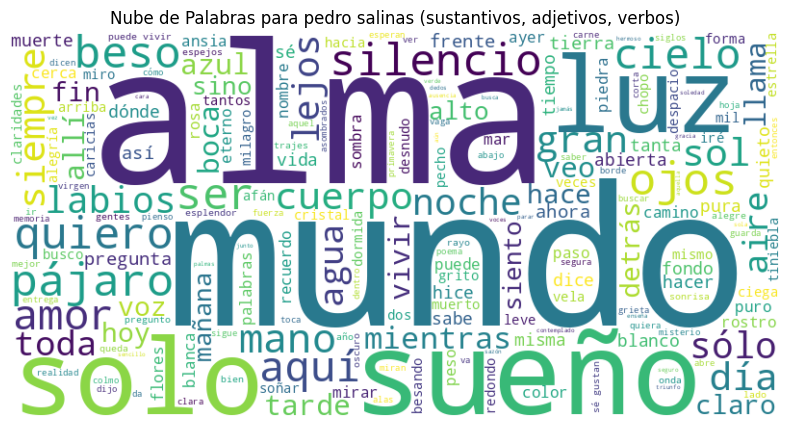

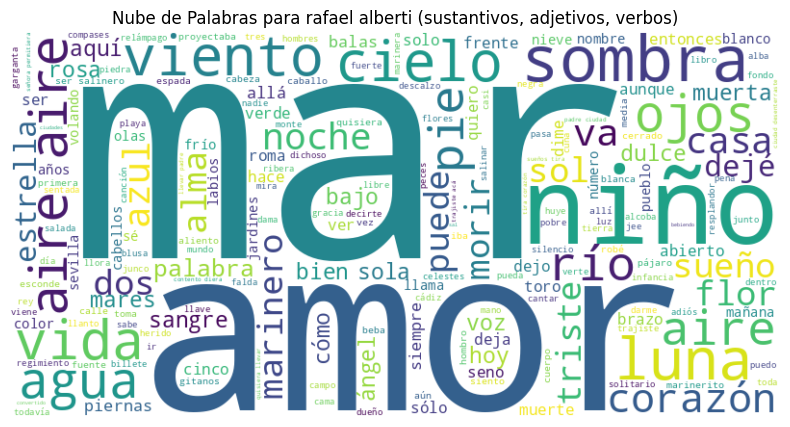

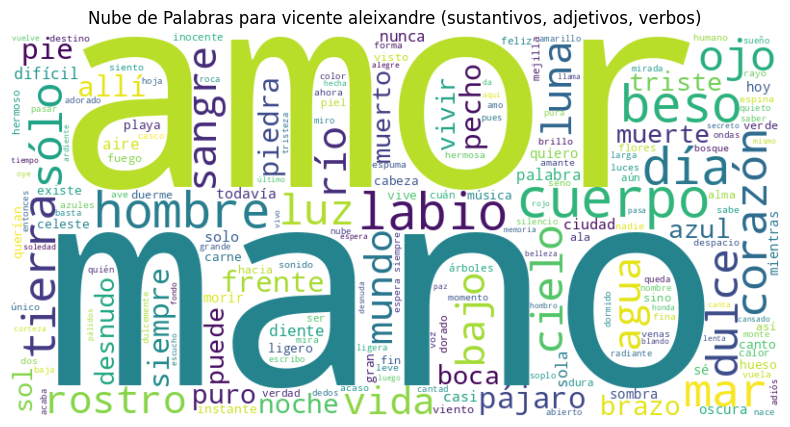

In [4]:
# Descargamos las stopwords de NLTK
nltk.download('stopwords')
nltk.download('punkt')

# Descargamos el etiquetador POS en español
nltk.download('averaged_perceptron_tagger')
nltk.download('universal_tagset')

# Creamos una función para filtrar sustantivos, adjetivos y verbos
def filtrar_pos(texto):
    stop_words = set(stopwords.words('spanish'))
    words = word_tokenize(texto)

    # Etiquetarmos gramaticalmente las palabras
    tagged_words = nltk.pos_tag(words, tagset='universal')

    # Creamos una lista de palabras adicionales para excluir
    exclusion_words = ['si', 'oh', 'ah', 'eh', 'tan', 'ay']  # Puedes agregar más palabras según sea necesario

    # Filtramos sustantivos, adjetivos y verbos, hacemos usaro de la lista -exclusion_words- creada algunas
    filtered_words = [word.lower() for word, pos in tagged_words if
                      word.lower() not in stop_words and word.isalpha() and
                      # sustantivos (N), adjetivos (J) y verbos (V)
                      (pos.startswith('N') or pos.startswith('J') or pos.startswith('V')) and
                      word.lower() not in exclusion_words]

    return ' '.join(filtered_words)


# Creamos una columna 'poema_filtrado_pos' en el DataFrame original
df['poema_filtrado_pos'] = df['poema'].apply(filtrar_pos)

# Creamos una nube de palabras para cada autor con texto filtrado
for autor in df['autor'].unique():
    text_filtrado = ' '.join(df[df['autor'] == autor]['poema_filtrado_pos'])

    # Creamos el objeto WordCloud
    wordcloud = WordCloud(width=800, height=400, background_color='white').generate(text_filtrado)

    # Mostramos la nube de palabras
    plt.figure(figsize=(10, 5))
    plt.imshow(wordcloud, interpolation='bilinear')
    plt.axis('off')
    plt.title(f'Nube de Palabras para {autor} (sustantivos, adjetivos, verbos)')
    plt.show()

spaCy - Usando técnicas de procesamiento de lenguaje natural (NLP) basadas en modelos preentrenados, en este caso spaCy.

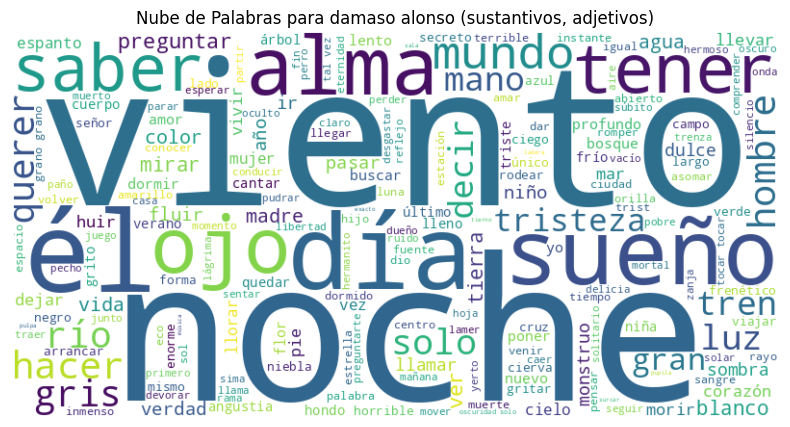

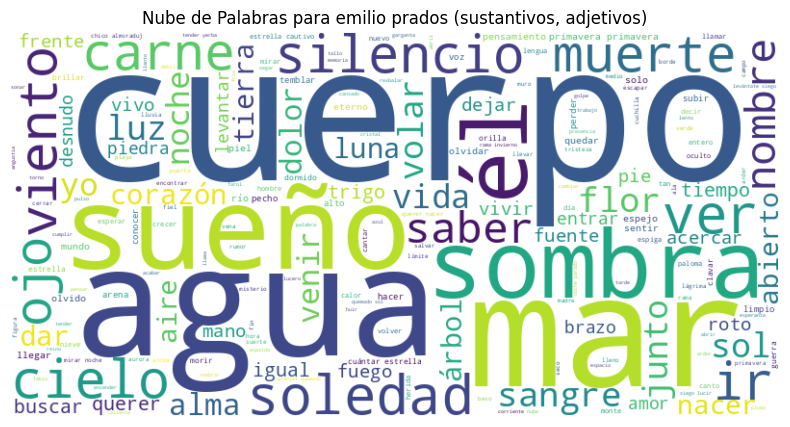

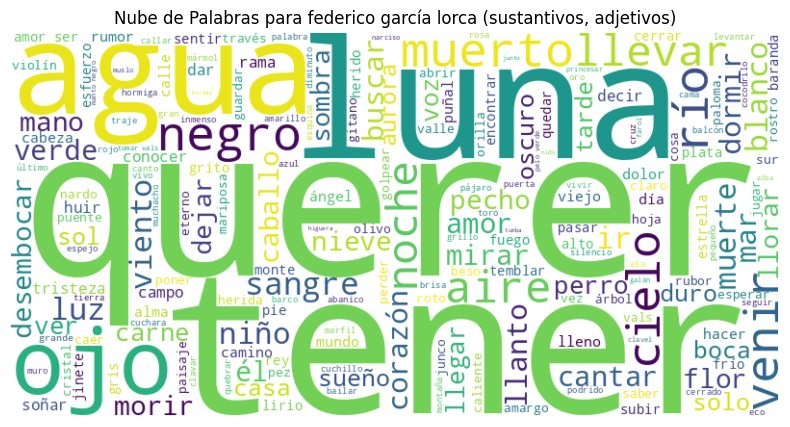

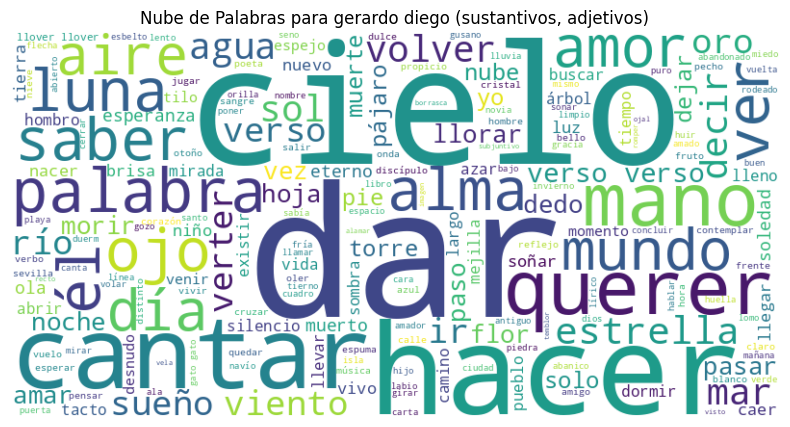

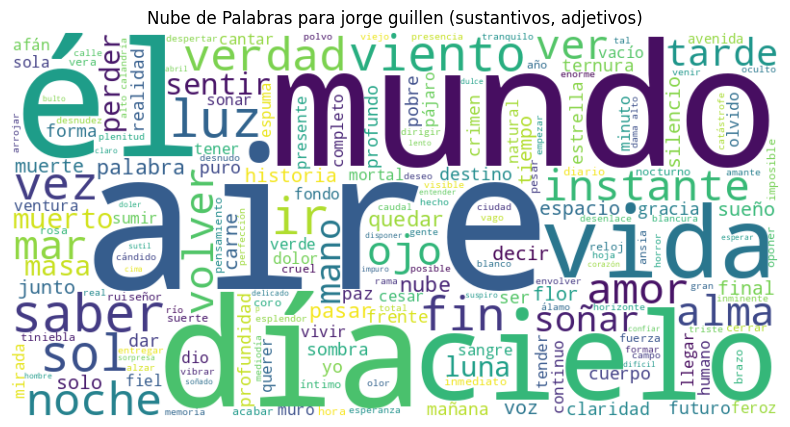

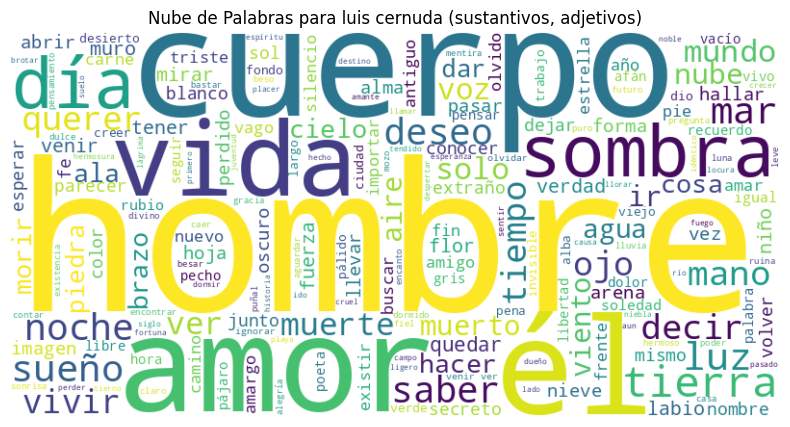

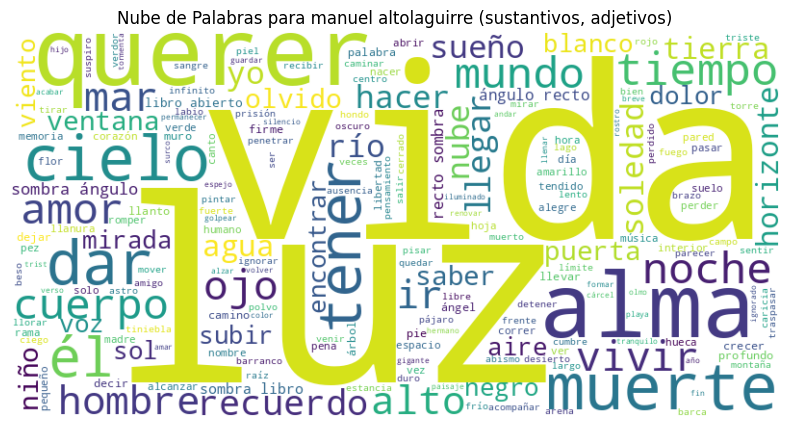

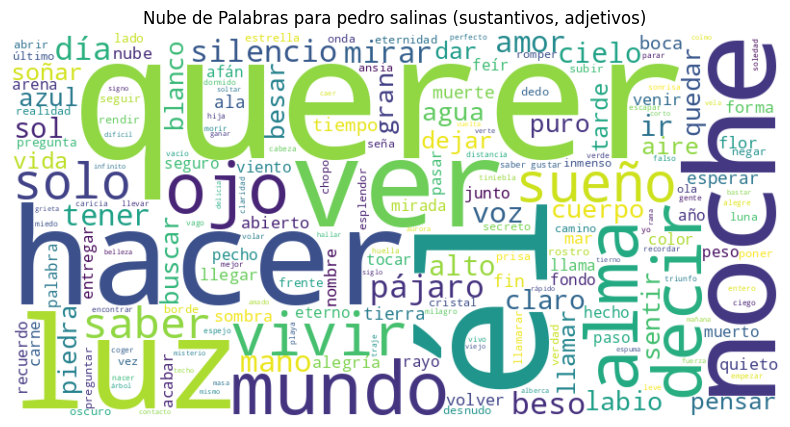

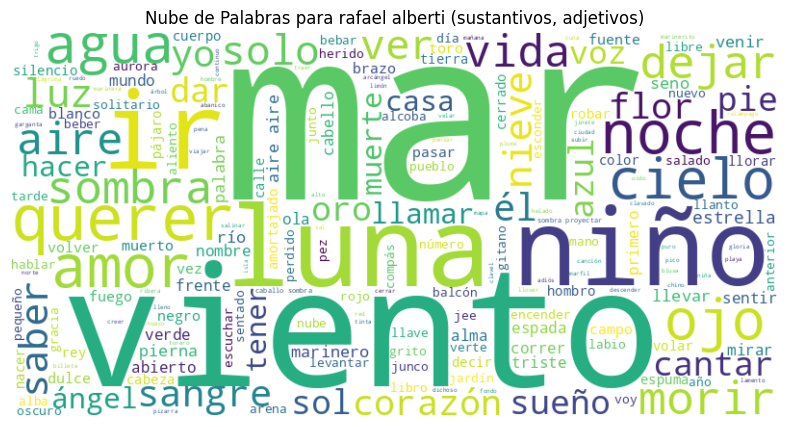

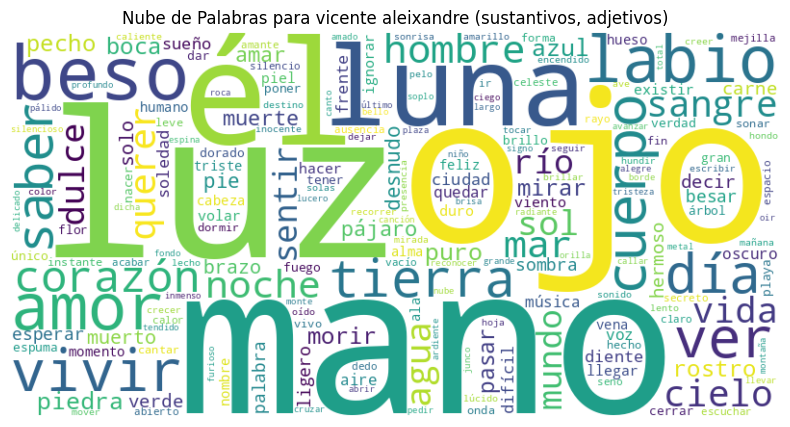

In [5]:
# Cargamos el modelo de spaCy para español
nlp = spacy.load('es_core_news_sm')

stop_words = set(stopwords.words('spanish'))

# Creamos una función para filtrar sustantivos y adjetivos con spaCy
def filtrar_sust_adj_spacy(texto):
    doc = nlp(texto)
    filtered_words = [token.lemma_.lower() for token in doc if
                      token.lemma_.lower() not in stop_words and token.is_alpha and
                      (token.pos_ == 'NOUN' or token.pos_ == 'ADJ' or token.pos_ == 'VERB')]
    return ' '.join(filtered_words)

# Creamos una columna 'poema_filtrado_spacy' en el DataFrame original
df['poema_filtrado_spacy'] = df['poema'].apply(filtrar_sust_adj_spacy)

# Creamos una nube de palabras para cada autor con texto filtrado
for autor in df['autor'].unique():
    text_filtrado = ' '.join(df[df['autor'] == autor]['poema_filtrado_spacy'])

    # Creamos el objeto WordCloud
    wordcloud = WordCloud(width=800, height=400, background_color='white').generate(text_filtrado)

    # Mostramos la nube de palabras
    plt.figure(figsize=(10, 5))
    plt.imshow(wordcloud, interpolation='bilinear')
    plt.axis('off')
    plt.title(f'Nube de Palabras para {autor} (sustantivos, adjetivos)')
    plt.show()


# ANÁLISIS DE SENTIMIENTOS

In [6]:
# Descargamos las stopwords de NLTK
nltk.download('stopwords')


# Inicializamos el analizador de sentimientos
sid = SentimentIntensityAnalyzer()

# Calculamos el sentimiento para cada poema
df['sentimiento'] = df['poema'].apply(lambda x: sid.polarity_scores(x)['compound'])

# Mostramos el DataFrame con el sentimiento
df[['autor', 'titulo', 'sentimiento']].head(10)

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


autor                        titulo  sentimiento
0  damaso alonso         a los que van a nacer      -0.8922
1  damaso alonso   a un río le llamaban carlos      -0.8299
2  damaso alonso  adiós al poeta rafael melero      -0.8642
3  damaso alonso                          amor       0.3753
4  damaso alonso                         burla      -0.3595
5  damaso alonso             calle del arrabal       0.0000
6  damaso alonso                  cancioncilla      -0.2500
7  damaso alonso                      cómo era      -0.5859
8  damaso alonso                  de profundis       0.9312
9  damaso alonso         destrucción inminente      -0.5707

In [7]:
# Creamos un Boxplot interactivo usando Plotly Express
fig = px.box(df, x='autor', y='sentimiento', title='Distribución de Sentimientos por Autor')
fig.show()

In [8]:
# Creamos el gráfico de puntos con facetas para cada uno de los autores
fig = px.scatter(df, x='sentimiento', y='numero_total_estrofas', color='autor',
                 title='Sentimiento por Número Total de Estrofas y Autor',
                 labels={'numero_total_estrofas': 'Número Total de Estrofas', 'sentimiento': 'Sentimiento'},
                 color_discrete_sequence=px.colors.qualitative.Set1,
                 facet_col='autor', facet_col_wrap=5, facet_col_spacing=0.1,
                 width=1500, height=750)

# Añadimos el título del poema como información adicional en cada punto
fig.update_traces(customdata=df['titulo'], hovertemplate='%{customdata}<br>' +
                  'Número Total de Estrofas: %{x}<br>' +
                  'Sentimiento: %{y}<br><br>')

# Ajustamos el diseño
fig.update_layout(title_text='Número Total de Estrofas por Sentimiento y Autor', showlegend=False)

# Mostramos el gráfico
fig.show()

In [9]:
# Reorganizamos las columnas del dataframe y seleccionamos la columna poema_filtrado_spacy ya que consideramos que realiza un mejor filtrado
# en base a las etiquetas POS que hemos seleccionado
df = df[['autor',	'titulo',	'poema', 'sentimiento', 'numero_total_estrofas','versos_por_estrofa', 'distribucion_silabas_estrofas', 'entropia_lexica_sust_adj', 'poema_filtrado_spacy']]
df.head(5)

autor                        titulo  \
0  damaso alonso         a los que van a nacer   
1  damaso alonso   a un río le llamaban carlos   
2  damaso alonso  adiós al poeta rafael melero   
3  damaso alonso                          amor   
4  damaso alonso                         burla   

                                               poema  sentimiento  \
0  \n¡Cuán cerca todavía\nde las manos de Dios! ¿...      -0.8922   
1  \nYo me senté en la orilla;\nquería preguntart...      -0.8299   
2  \n        no hay que llorarte, melero.\n      ...      -0.8642   
3  \n¡Primavera feroz! Va mi ternura\npor las más...       0.3753   
4  \npor las praderas hondas,\navizor y azoradas\...      -0.3595   

   numero_total_estrofas           versos_por_estrofa  \
0                      4               [12, 11, 7, 8]   
1                      8  [4, 4, 8, 9, 10, 11, 7, 13]   
2                      5              [6, 6, 6, 6, 1]   
3                      4                 [4, 4, 3, 3]   
4                      3                    [4, 4, 4]   

                       distribucion_silabas_estrofas  \
0  {1: [6, 12, 11, 11, 12, 10, 13, 15, 9, 13, 13,...   
1  {1: [8, 14, 19, 25], 2: [15, 18, 4, 12], 3: [1...   
2  {1: [9, 9, 4, 9, 10, 5], 2: [9, 8, 5, 9, 10, 4...   
3  {1: [12, 11, 13, 12], 2: [14, 13, 12, 12], 3: ...   
4  {1: [8, 6, 6, 6], 2: [7, 8, 7, 8], 3: [7, 6, 6...   

   entropia_lexica_sust_adj                               poema_filtrado_spacy  
0                  5.998270  mano aliento rugir cedro pupila rabo oro vedij...  
1                  5.776153  sentar orilla querer preguntarte preguntarme s...  
2                  4.706891  llorartir melero llanto querer patear gritar h...  
3                  5.072140  feroz ir ternura hondo vena derramado fresco h...  
4                  4.368523  pradera hondo avizor azorada cierva huida idea...

# Creación de un dataframe con las columnas de frecuencia léxica POS y spaCy

Creamos un dataframe que contiene las mismas columnas que df; pero añadimos dos columnas con las listas de las cinco palabras más frecuentes por autor según método POS y spaCy

In [10]:
# Datos para crear el DataFrame original
data = {
    'autor': ['Damaso Alonso', 'Emilio Prados', 'Federico García Lorca', 'Gerardo Diego', 'Jorge Guillen', 'Luis Cernuda', 'Manuel Altolaguirre', 'Pedro Salinas', 'Rafael Alberti', 'Vicente Aleixandre'],
    'palabras: POS': ['Dios Noche Sueño Día Alma', 'Cuerpo Mar Agua Cielo Sueño','Amor Quiero Verde Muerto Río', 'Cielo Día Versos Verte Sueño', 'Aire Bajo Ser Día Cielo', 'Hombre Cuerpo Amor Sombra Día','Alma Cielo Amor Cuerpo Tiempo', 'Alma Mundo Sueño Luz Solo','Mar Amor Niño Sombra Luna','Mano Amor Cuerpo Beso Día'],
    'palabras: spaCy': ['Viento Noche Él Día Alma', 'Cuerpo Mar Agua Él Sueño', 'Querer Tener Luna Agua Ojo', 'Cielo Dar Hacer Mano Cantar','Aire Mundo Él Luz Cielo', 'Hombre Cuerpo Amor Sombra Él','Alma Luz Querer Vida Muerte', 'Querer Hacer Él Luz Noche', 'Mar Querer Niño Viento Luna', 'Mano Él Ojo Beso Luz'],
}

# Crear DataFrame original
df_resultado = pd.DataFrame(data)

# Convertir todas las columnas a minúsculas
df_resultado['autor'] = df_resultado['autor'].str.lower()
df_resultado['palabras: POS'] = df_resultado['palabras: POS'].str.lower()
df_resultado['palabras: spaCy'] = df_resultado['palabras: spaCy'].str.lower()

# Fusionar ambos DataFrames en función de la columna 'autor'
merged_df = pd.merge(df, df_resultado, left_on='autor', right_on='autor', how='left')

# Convertir las columnas a minúsculas
merged_df['palabras: POS'] = merged_df['palabras: POS'].str.lower()
merged_df['palabras: spaCy'] = merged_df['palabras: spaCy'].str.lower()

# Imprimir el DataFrame resultante
merged_df

autor                        titulo  \
0         damaso alonso         a los que van a nacer   
1         damaso alonso   a un río le llamaban carlos   
2         damaso alonso  adiós al poeta rafael melero   
3         damaso alonso                          amor   
4         damaso alonso                         burla   
..                  ...                           ...   
495  vicente aleixandre           unas pocas palabras   
496  vicente aleixandre                unidad en ella   
497  vicente aleixandre               ven siempre ven   
498  vicente aleixandre                verdad siempre   
499  vicente aleixandre                          vida   

                                                 poema  sentimiento  \
0    \n¡Cuán cerca todavía\nde las manos de Dios! ¿...      -0.8922   
1    \nYo me senté en la orilla;\nquería preguntart...      -0.8299   
2    \n        no hay que llorarte, melero.\n      ...      -0.8642   
3    \n¡Primavera feroz! Va mi ternura\npor las más...       0.3753   
4    \npor las praderas hondas,\navizor y azoradas\...      -0.3595   
..                                                 ...          ...   
495  \n            unas pocas palabras\n           ...      -0.5267   
496  \n        Cuerpo feliz que fluye entre mis man...       0.7783   
497  \n            no te acerques. tu frente, tu ar...      -0.1260   
498  \n        Sí, sí, es verdad, es la única verda...      -0.5267   
499  \n            un pájaro de papel en el pecho\n...       0.0516   

     numero_total_estrofas           versos_por_estrofa  \
0                        4               [12, 11, 7, 8]   
1                        8  [4, 4, 8, 9, 10, 11, 7, 13]   
2                        5              [6, 6, 6, 6, 1]   
3                        4                 [4, 4, 3, 3]   
4                        3                    [4, 4, 4]   
..                     ...                          ...   
495                      1                         [19]   
496                      6           [4, 4, 4, 4, 4, 7]   
497                      8     [6, 6, 5, 4, 4, 4, 4, 4]   
498                      2                       [9, 5]   
499                      1                         [12]   

                         distribucion_silabas_estrofas  \
0    {1: [6, 12, 11, 11, 12, 10, 13, 15, 9, 13, 13,...   
1    {1: [8, 14, 19, 25], 2: [15, 18, 4, 12], 3: [1...   
2    {1: [9, 9, 4, 9, 10, 5], 2: [9, 8, 5, 9, 10, 4...   
3    {1: [12, 11, 13, 12], 2: [14, 13, 12, 12], 3: ...   
4    {1: [8, 6, 6, 6], 2: [7, 8, 7, 8], 3: [7, 6, 6...   
..                                                 ...   
495  {1: [6, 18, 20, 16, 21, 14, 14, 13, 12, 13, 16...   
496  {1: [13, 12, 16, 15], 2: [14, 14, 17, 12], 3: ...   
497  {1: [20, 8, 16, 17, 14, 29], 2: [15, 18, 14, 1...   
498  {1: [13, 10, 13, 12, 12, 12, 13, 12, 8], 2: [1...   
499  {1: [11, 15, 14, 15, 10, 10, 11, 15, 18, 10, 1...   

     entropia_lexica_sust_adj  \
0                    5.998270   
1                    5.776153   
2                    4.706891   
3                    5.072140   
4                    4.368523   
..                        ...   
495                  5.360902   
496                  5.836714   
497                  6.174614   
498                  4.582119   
499                  4.852169   

                                  poema_filtrado_spacy  \
0    mano aliento rugir cedro pupila rabo oro vedij...   
1    sentar orilla querer preguntarte preguntarme s...   
2    llorartir melero llanto querer patear gritar h...   
3    feroz ir ternura hondo vena derramado fresco h...   
4    pradera hondo avizor azorada cierva huida idea...   
..                                                 ...   
495  palabra oído decir poca fe hombre incierto viv...   
496  cuerpo feliz fluir mano rostro amado contemplo...   
497  acerqu frente ardiente encendido huella beso r...   
498  verdad único verdad ojo entreabierto luz nacid...   
499  pájaro papel pecho decir tiempo be

In [11]:
# Comprobamos que no haya valores NaN en cada columna
nan_en_columnas = merged_df.isna().any()

# Comprobamos que no haya valores NaN en cada fila
nan_en_filas = merged_df.isna().any(axis=1)

# Filtramos filas con NaN
filas_con_nan = merged_df[nan_en_filas]

# Las mostramos
print("Columnas con NaN:")
nan_en_columnas

print("\nFilas con NaN:")
filas_con_nan

Columnas con NaN:

Filas con NaN:


Empty DataFrame
Columns: [autor, titulo, poema, sentimiento, numero_total_estrofas, versos_por_estrofa, distribucion_silabas_estrofas, entropia_lexica_sust_adj, poema_filtrado_spacy, palabras: POS, palabras: spaCy]
Index: []

# CLASIFICACIÓN CON REGRESIÓN LOGÍSTICA

## Modelo1 - Usando solo la variable que contiene el texto del poema

Precisión del modelo: 0.52


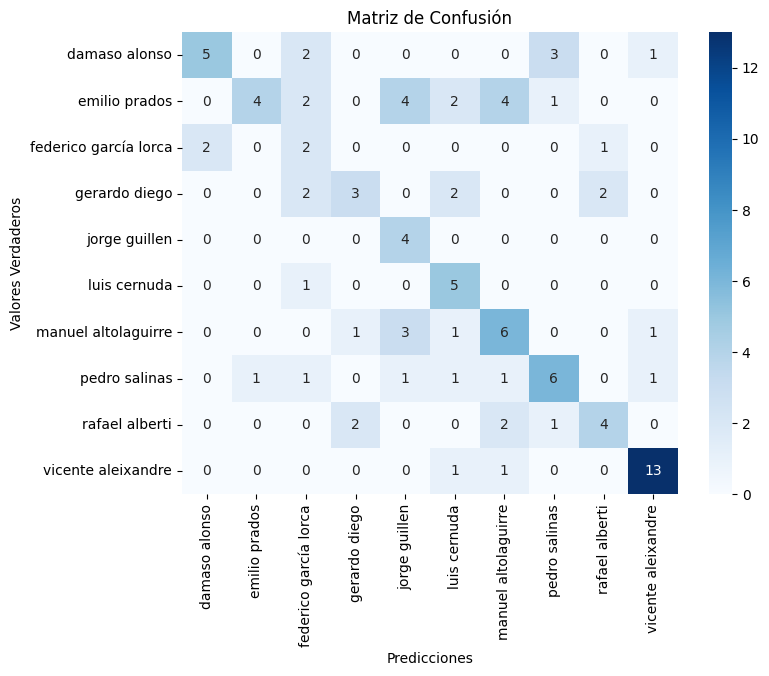

Estadístico de Clasificación:
                        precision    recall  f1-score   support

        damaso alonso       0.71      0.45      0.56        11
        emilio prados       0.80      0.24      0.36        17
federico garcía lorca       0.20      0.40      0.27         5
        gerardo diego       0.50      0.33      0.40         9
        jorge guillen       0.33      1.00      0.50         4
         luis cernuda       0.42      0.83      0.56         6
  manuel altolaguirre       0.43      0.50      0.46        12
        pedro salinas       0.55      0.50      0.52        12
       rafael alberti       0.57      0.44      0.50         9
   vicente aleixandre       0.81      0.87      0.84        15

             accuracy                           0.52       100
            macro avg       0.53      0.56      0.50       100
         weighted avg       0.60      0.52      0.51       100



In [12]:
# Dividimos los datos en conjuntos de entrenamiento y prueba
train_data, test_data = train_test_split(df, test_size=0.2, random_state=42)

# TF-IDF Vectorization
vectorizer = TfidfVectorizer(max_features=1000)
X_train = vectorizer.fit_transform(train_data['poema'])
X_test = vectorizer.transform(test_data['poema'])

# Entrenamos un modelo de regresión logística
model = LogisticRegression()
model.fit(X_train, train_data['autor'])

# Usando el modelo creado predecimos a partir de los datos de test
predictions = model.predict(X_test)

# Calculamos la precisión
accuracy_modelo_log_1 = accuracy_score(test_data['autor'], predictions)
print(f'Precisión del modelo: {accuracy_modelo_log_1 }')

# Creamos matriz de Confusión y la visualizamos
conf_matrix = confusion_matrix(test_data['autor'], predictions)
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=model.classes_, yticklabels=model.classes_)
plt.xlabel('Predicciones')
plt.ylabel('Valores Verdaderos')
plt.title('Matriz de Confusión')
plt.show()

# Creamos el informe de Clasificación
class_report = classification_report(test_data['autor'], predictions)
print('Estadístico de Clasificación:\n', class_report)

## MODELO 2 - Usando todas las variables

Precisión del modelo: 0.48


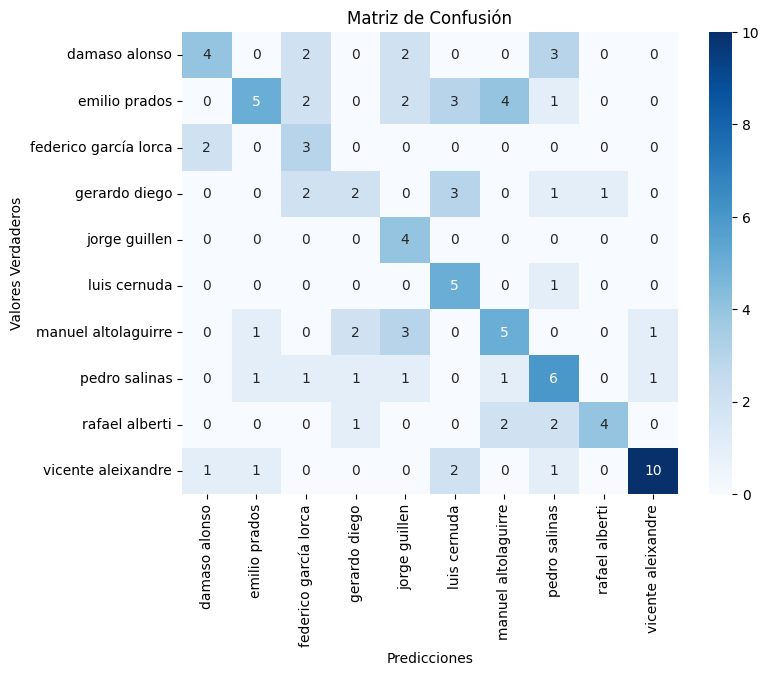

Estadístico de Clasificación:
                        precision    recall  f1-score   support

        damaso alonso       0.57      0.36      0.44        11
        emilio prados       0.62      0.29      0.40        17
federico garcía lorca       0.30      0.60      0.40         5
        gerardo diego       0.33      0.22      0.27         9
        jorge guillen       0.33      1.00      0.50         4
         luis cernuda       0.38      0.83      0.53         6
  manuel altolaguirre       0.42      0.42      0.42        12
        pedro salinas       0.40      0.50      0.44        12
       rafael alberti       0.80      0.44      0.57         9
   vicente aleixandre       0.83      0.67      0.74        15

             accuracy                           0.48       100
            macro avg       0.50      0.53      0.47       100
         weighted avg       0.55      0.48      0.48       100



In [13]:
# Dividimos los datos en conjuntos de entrenamiento y prueba
train_data, test_data = train_test_split(df, test_size=0.2, random_state=42)

# Realizamos la vectorización TF-IDF para la columna 'poema'
vectorizer_poema = TfidfVectorizer(max_features=1000)
X_train_poema = vectorizer_poema.fit_transform(train_data['poema'])
X_test_poema = vectorizer_poema.transform(test_data['poema'])

# Normalizamos las columnas numéricas para minimizar las distorsiones procedentes de diferentes escalas numéricas
scaler = MinMaxScaler()
train_data[['sentimiento', 'numero_total_estrofas', 'entropia_lexica_sust_adj']] = scaler.fit_transform(train_data[['sentimiento', 'numero_total_estrofas', 'entropia_lexica_sust_adj']])
test_data[['sentimiento', 'numero_total_estrofas', 'entropia_lexica_sust_adj']] = scaler.transform(test_data[['sentimiento', 'numero_total_estrofas', 'entropia_lexica_sust_adj']])

# Combinamos las características numéricas con las vectorizadas de 'poema'
X_train_combined = hstack([X_train_poema, train_data[['sentimiento', 'numero_total_estrofas', 'entropia_lexica_sust_adj']].values])
X_test_combined = hstack([X_test_poema, test_data[['sentimiento', 'numero_total_estrofas', 'entropia_lexica_sust_adj']].values])

# Entrenamos el modelo de regresión logística
model = LogisticRegression()
model.fit(X_train_combined, train_data['autor'])

# Con el modelo entrenado realizamos las predicciones con los datos del conjunto test
predictions = model.predict(X_test_combined)

# Calculamos la precisión
accuracy_modelo_log_2 = accuracy_score(test_data['autor'], predictions)
print(f'Precisión del modelo: {accuracy_modelo_log_2}')

# Creamos la matriz de Confusión y su visualización
conf_matrix = confusion_matrix(test_data['autor'], predictions)
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=model.classes_, yticklabels=model.classes_)
plt.xlabel('Predicciones')
plt.ylabel('Valores Verdaderos')
plt.title('Matriz de Confusión')
plt.show()

# Creamos el informe de Clasificación
class_report = classification_report(test_data['autor'], predictions)
print('Estadístico de Clasificación:\n', class_report)

## MODELO 3 - Seleccionando los autores con un estilo literario más definido y usando solo la variable -poemas-

Precisión del modelo: 0.72


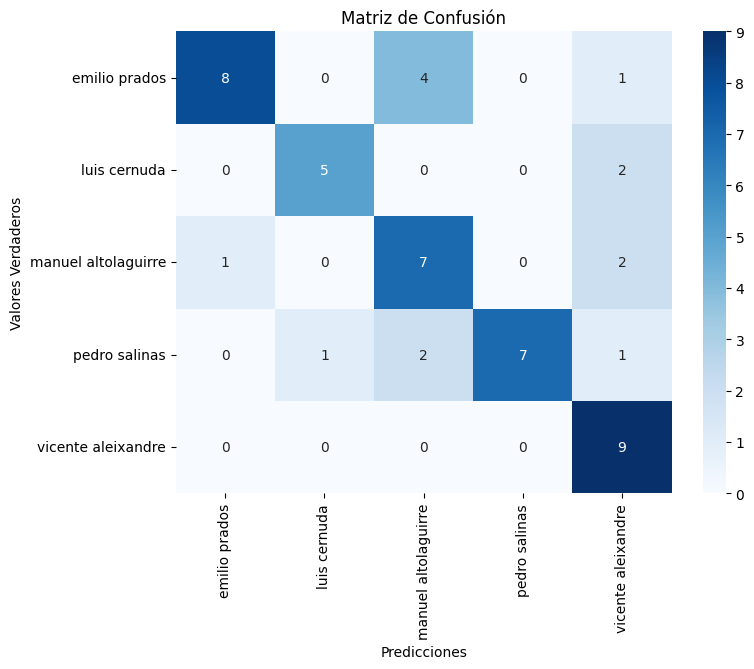

Estadístico de Clasificación:
                      precision    recall  f1-score   support

      emilio prados       0.89      0.62      0.73        13
       luis cernuda       0.83      0.71      0.77         7
manuel altolaguirre       0.54      0.70      0.61        10
      pedro salinas       1.00      0.64      0.78        11
 vicente aleixandre       0.60      1.00      0.75         9

           accuracy                           0.72        50
          macro avg       0.77      0.73      0.73        50
       weighted avg       0.78      0.72      0.72        50



In [14]:
# Filtramos datos solo para los autores específicos
autores_interesantes = ['vicente aleixandre', 'pedro salinas', 'luis cernuda', 'manuel altolaguirre', 'emilio prados']
df_interesantes = df[df['autor'].isin(autores_interesantes)]

# Dividimos los datos en conjuntos de entrenamiento y prueba
train_data, test_data = train_test_split(df_interesantes, test_size=0.2, random_state=42)

# Aplicamos TF-IDF Vectorization para la columna 'poema'
vectorizer = TfidfVectorizer(max_features=1000)
X_train = vectorizer.fit_transform(train_data['poema'])
X_test = vectorizer.transform(test_data['poema'])

# Entrenamos el modelo de regresión logística
model = LogisticRegression()
model.fit(X_train, train_data['autor'])

# Predección sobre el conjunto test de nuestro modelo
predictions = model.predict(X_test)

# Calculamos la precisión
accuracy_modelo_log_3 = accuracy_score(test_data['autor'], predictions)
print(f'Precisión del modelo: {accuracy_modelo_log_3}')

# Creamos la Matriz de Confusión
conf_matrix = confusion_matrix(test_data['autor'], predictions)
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=model.classes_, yticklabels=model.classes_)
plt.xlabel('Predicciones')
plt.ylabel('Valores Verdaderos')
plt.title('Matriz de Confusión')
plt.show()

# Creamos el informe de la Clasificación
class_report = classification_report(test_data['autor'], predictions)
print('Estadístico de Clasificación:\n', class_report)


## MODELO 4 - Selección de autores, uso de la variable -poema- y las variables creadas auxiliares

Precisión del modelo: 0.76


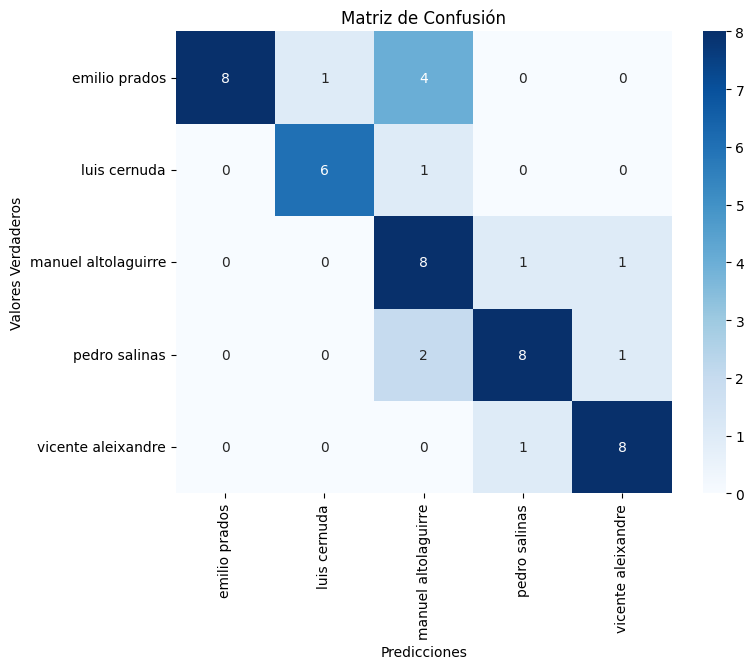

Estadístico de Clasificación:
                      precision    recall  f1-score   support

      emilio prados       1.00      0.62      0.76        13
       luis cernuda       0.86      0.86      0.86         7
manuel altolaguirre       0.53      0.80      0.64        10
      pedro salinas       0.80      0.73      0.76        11
 vicente aleixandre       0.80      0.89      0.84         9

           accuracy                           0.76        50
          macro avg       0.80      0.78      0.77        50
       weighted avg       0.81      0.76      0.77        50



In [15]:
# Filtramos datos solo para los autores específicos
autores_interesantes = ['vicente aleixandre', 'pedro salinas', 'luis cernuda', 'manuel altolaguirre', 'emilio prados']
df_interesantes = df[df['autor'].isin(autores_interesantes)]


# Dividimos los datos en conjuntos de entrenamiento y prueba
train_data, test_data = train_test_split(df_interesantes, test_size=0.2, random_state=42)

# Aplicamos TF-IDF Vectorization para la columna 'poema'
vectorizer_poema = TfidfVectorizer(max_features=1000)
X_train_poema = vectorizer_poema.fit_transform(train_data['poema'])
X_test_poema = vectorizer_poema.transform(test_data['poema'])

# Normalizamos las columnas numéricas
scaler = MinMaxScaler()
train_data[['sentimiento', 'numero_total_estrofas', 'entropia_lexica_sust_adj']] = scaler.fit_transform(train_data[['sentimiento', 'numero_total_estrofas', 'entropia_lexica_sust_adj']])
test_data[['sentimiento', 'numero_total_estrofas', 'entropia_lexica_sust_adj']] = scaler.transform(test_data[['sentimiento', 'numero_total_estrofas', 'entropia_lexica_sust_adj']])

# Combinamos las características numéricas con las vectorizadas de 'poema'
X_train_combined = hstack([X_train_poema, train_data[['sentimiento', 'numero_total_estrofas', 'entropia_lexica_sust_adj']].values])
X_test_combined = hstack([X_test_poema, test_data[['sentimiento', 'numero_total_estrofas', 'entropia_lexica_sust_adj']].values])

# Entrenamos el modelo de regresión logística
model = LogisticRegression()
model.fit(X_train_combined, train_data['autor'])

# Predección sobre el conjunto test de nuestro modelo
predictions = model.predict(X_test_combined)

# Calculamos la precisión
accuracy_modelo_log_4 = accuracy_score(test_data['autor'], predictions)
print(f'Precisión del modelo: {accuracy_modelo_log_4}')

# Creamos la Matriz de Confusión
conf_matrix = confusion_matrix(test_data['autor'], predictions)
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=model.classes_, yticklabels=model.classes_)
plt.xlabel('Predicciones')
plt.ylabel('Valores Verdaderos')
plt.title('Matriz de Confusión')
plt.show()

# Creamos el informe de la Clasificación
class_report = classification_report(test_data['autor'], predictions)
print('Estadístico de Clasificación:\n', class_report)

## ANÁLISIS DE RESULTADOS PARA LOS MODELOS DE REGRESIONES LOGÍSTICAS

In [16]:
# Creamos un DataFrame con la información de las variables que se incluyen en los modelos así como el valor de accuracy obtenido
data = {
    'Modelo': ['Modelo 1 (solo poema)', 'Modelo 2 (poema + variables auxiliares)',
               'Modelo 3 (poema + autores con estilo literario marcado)',
               'Modelo 4 (poema + variables auxiliares + autores con estilo literario marcado)'],
    'Accuracy': [accuracy_modelo_log_1, accuracy_modelo_log_2, accuracy_modelo_log_3, accuracy_modelo_log_4]
}

df_accuracy_RN = pd.DataFrame(data)

# Creamos el gráfico de puntos con líneas
fig = px.line(df_accuracy_RN, x='Modelo', y='Accuracy', text='Accuracy', title='Accuracy de los Modelos basados en regresiones logarítmicas',
             labels={'Accuracy': 'Accuracy del Modelo'})

# Personalizamos el diseño del gráfico
fig.update_traces(mode='markers+lines', marker=dict(color='red', line=dict(color='black', width=2)),
                  textposition='top center', textfont=dict(color='black'))

fig.update_layout(title_text='Accuracy de los modelos de Regresiones Logarítmicas',
                  xaxis_title='Modelos', yaxis_title='Accuracy',
                  template='plotly_dark')  # Fondo negro

# Mostramos el gráfico
fig.show()

# CLASIFICACIÓN CON REDES NEURONALES

## MODELO 1: Red neuronal para todos los autores y solo usando la columna de texto -poema-

In [17]:
# Dividimos los datos en conjuntos de entrenamiento y prueba
train_data, test_data = train_test_split(df, test_size=0.2, random_state=42)

# Tokenizamos el texto
tokenizer = Tokenizer()
tokenizer.fit_on_texts(train_data['poema'])

# Convertimos el texto a secuencias de números
X_train = tokenizer.texts_to_sequences(train_data['poema'])
X_test = tokenizer.texts_to_sequences(test_data['poema'])

# Realizamos un -Pad sequences- para tener la misma longitud
X_train = pad_sequences(X_train)
X_test = pad_sequences(X_test, maxlen=X_train.shape[1])

# Inicializamos el codificador de etiquetas
label_encoder = LabelEncoder()

# Convertimos las etiquetas de 'autor' a valores numéricos
train_labels_encoded = label_encoder.fit_transform(train_data['autor'])
test_labels_encoded = label_encoder.transform(test_data['autor'])

# Creamos el modelo LSTM
model = Sequential()
model.add(Embedding(input_dim=len(tokenizer.word_index) + 1, output_dim=100, input_length=X_train.shape[1]))
model.add(LSTM(100))
model.add(Dense(len(df['autor'].unique()), activation='softmax'))

# Compilamos el modelo
model.compile(loss='sparse_categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

# Entrenamos el modelo
model.fit(X_train, train_labels_encoded, epochs=50, validation_split=0.1, batch_size=32)

# Evaluamos el modelo en el conjunto de prueba
loss, accuracy = model.evaluate(X_test, test_labels_encoded)
print(f'Precisión del modelo en el conjunto de prueba: {accuracy}')

# Realizamos las predicciones usando el modelo entrenado
predictions = model.predict(X_test)

# Convertimos las predicciones a etiquetas de clase
predicted_labels = np.argmax(predictions, axis=1)

Epoch 1/50
12/12 [==============================] - 27s 2s/step - loss: 2.3038 - accuracy: 0.1194 - val_loss: 2.3005 - val_accuracy: 0.1750
Epoch 2/50
12/12 [==============================] - 12s 971ms/step - loss: 2.2723 - accuracy: 0.3750 - val_loss: 2.2960 - val_accuracy: 0.1500
Epoch 3/50
12/12 [==============================] - 12s 989ms/step - loss: 2.2260 - accuracy: 0.3056 - val_loss: 2.2848 - val_accuracy: 0.1750
Epoch 4/50
12/12 [==============================] - 11s 905ms/step - loss: 2.1256 - accuracy: 0.5639 - val_loss: 2.2929 - val_accuracy: 0.2500
Epoch 5/50
12/12 [==============================] - 12s 980ms/step - loss: 1.8815 - accuracy: 0.5222 - val_loss: 2.2222 - val_accuracy: 0.2250
Epoch 6/50
12/12 [==============================] - 12s 1s/step - loss: 1.5422 - accuracy: 0.5917 - val_loss: 2.2071 - val_accuracy: 0.2000
Epoch 7/50
12/12 [==============================] - 12s 997ms/step - loss: 1.1667 - accuracy: 0.7083 - val_loss: 2.3344 - val_accuracy: 0.1500
Epoch

Precisión: 0.3449
Recall: 0.3300
F1-Score: 0.3211


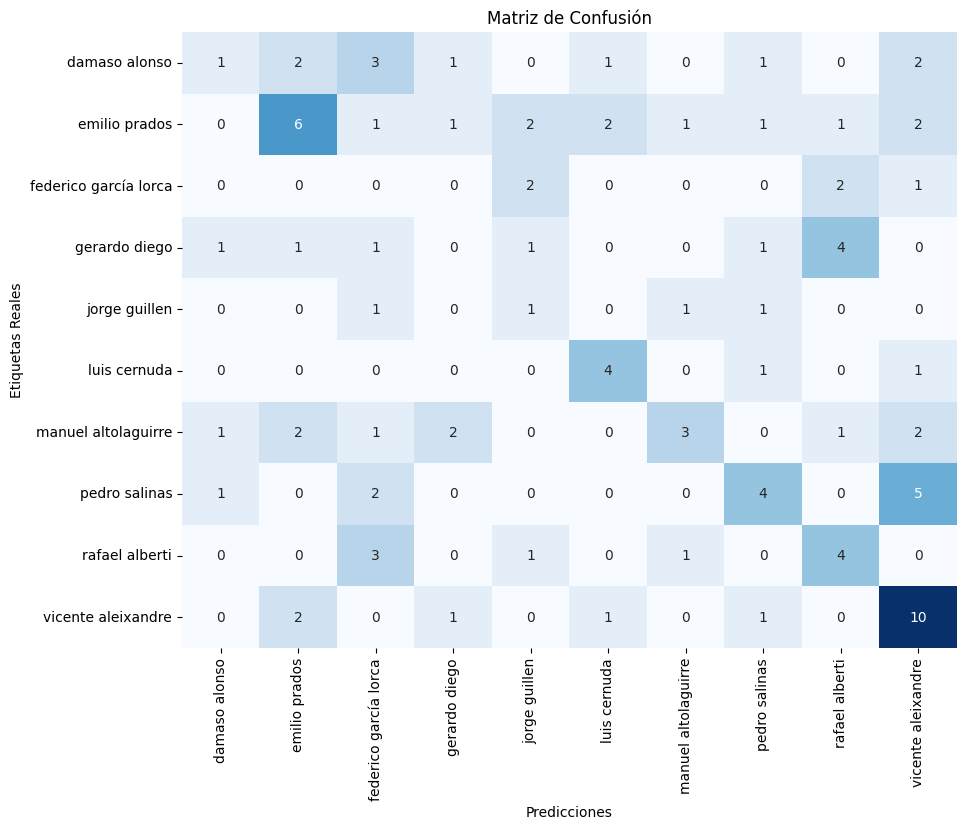

In [18]:
# Calculamos y mostramos métricas adicionales
precision = precision_score(test_labels_encoded, predicted_labels, average='weighted')
recall = recall_score(test_labels_encoded, predicted_labels, average='weighted')
f1 = f1_score(test_labels_encoded, predicted_labels, average='weighted')


print(f'Precisión: {precision:.4f}')
print(f'Recall: {recall:.4f}')
print(f'F1-Score: {f1:.4f}')

# Creamos la matriz de confusión
conf_matrix = confusion_matrix(test_labels_encoded, predicted_labels)

# Visualizamos la matriz de confusión usando seaborn
plt.figure(figsize=(10, 8))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', cbar=False,
            xticklabels=label_encoder.classes_, yticklabels=label_encoder.classes_)
plt.xlabel('Predicciones')
plt.ylabel('Etiquetas Reales')
plt.title('Matriz de Confusión')
plt.show()

# Guardamos el valor de precisión para este modelo en una variable
precision_modelo_RN_1 = accuracy


## MODELO 2: Red neuronal usando todos autores, variable -poema- y variables auxiliares creadas

In [19]:
# Seleccionamos todos los autores
autores_interesantes = df['autor'].unique()
df_interesantes = df[df['autor'].isin(autores_interesantes)]

# Dividir los datos en conjuntos de entrenamiento y prueba
train_data, test_data = train_test_split(df_interesantes, test_size=0.2, random_state=42)

# Normalizar las columnas numéricas
scaler = MinMaxScaler()
numeric_columns = ['sentimiento', 'numero_total_estrofas', 'entropia_lexica_sust_adj']

train_data[numeric_columns] = scaler.fit_transform(train_data[numeric_columns])
test_data[numeric_columns] = scaler.transform(test_data[numeric_columns])

# Tokenizar el texto
tokenizer = Tokenizer()
tokenizer.fit_on_texts(train_data['poema'])

# Convertir el texto a secuencias de números
X_train_text = tokenizer.texts_to_sequences(train_data['poema'])
X_test_text = tokenizer.texts_to_sequences(test_data['poema'])

# Pad sequences para tener la misma longitud
X_train_text = pad_sequences(X_train_text)
X_test_text = pad_sequences(X_test_text, maxlen=X_train_text.shape[1])

# Inicializar el codificador de etiquetas
label_encoder = LabelEncoder()

# Convertir las etiquetas de 'autor' a valores numéricos
train_labels_encoded = label_encoder.fit_transform(train_data['autor'])
test_labels_encoded = label_encoder.transform(test_data['autor'])

# Crear el modelo LSTM mejorado con características adicionales
input_text = Input(shape=(X_train_text.shape[1],))
embedding_layer = Embedding(input_dim=len(tokenizer.word_index) + 1, output_dim=200, input_length=X_train_text.shape[1])(input_text)
lstm_layer = LSTM(200, return_sequences=True)(embedding_layer)
lstm_layer = LSTM(100)(lstm_layer)
dropout_layer = Dropout(0.2)(lstm_layer)

# Agregar las columnas numéricas como entrada adicional
input_numeric = Input(shape=(len(numeric_columns),))
concatenated = concatenate([dropout_layer, input_numeric])

dense_layer = Dense(len(autores_interesantes), activation='softmax')(concatenated)

# Crear el modelo
model = Model(inputs=[input_text, input_numeric], outputs=dense_layer)

# Compilar el modelo
model.compile(loss='sparse_categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

# Entrenar el modelo con características adicionales
model.fit([X_train_text, train_data[numeric_columns]], train_labels_encoded, epochs=50, validation_split=0.1, batch_size=32)

# Evaluar el modelo en el conjunto de prueba
loss, accuracy = model.evaluate([X_test_text, test_data[numeric_columns]], test_labels_encoded)
print(f'Precisión del modelo en el conjunto de prueba: {accuracy}')

# Realizar predicciones usando el modelo entrenado
predictions = model.predict([X_test_text, test_data[numeric_columns]])

# Convertir las predicciones a etiquetas de clase
predicted_labels = np.argmax(predictions, axis=1)

Epoch 1/50
12/12 [==============================] - 62s 5s/step - loss: 2.3025 - accuracy: 0.1056 - val_loss: 2.2905 - val_accuracy: 0.1750
Epoch 2/50
12/12 [==============================] - 59s 5s/step - loss: 2.2369 - accuracy: 0.2389 - val_loss: 2.2022 - val_accuracy: 0.1750
Epoch 3/50
12/12 [==============================] - 56s 5s/step - loss: 1.9202 - accuracy: 0.4167 - val_loss: 2.1636 - val_accuracy: 0.1750
Epoch 4/50
12/12 [==============================] - 58s 5s/step - loss: 1.3331 - accuracy: 0.6056 - val_loss: 2.3584 - val_accuracy: 0.2000
Epoch 5/50
12/12 [==============================] - 57s 5s/step - loss: 0.7474 - accuracy: 0.7944 - val_loss: 2.3745 - val_accuracy: 0.2500
Epoch 6/50
12/12 [==============================] - 61s 5s/step - loss: 0.3699 - accuracy: 0.9444 - val_loss: 2.5645 - val_accuracy: 0.3000
Epoch 7/50
12/12 [==============================] - 56s 5s/step - loss: 0.1908 - accuracy: 0.9750 - val_loss: 2.7984 - val_accuracy: 0.1750
Epoch 8/50
12/12 [==

Precisión: 0.3148
Recall: 0.3000
F1-Score: 0.2780


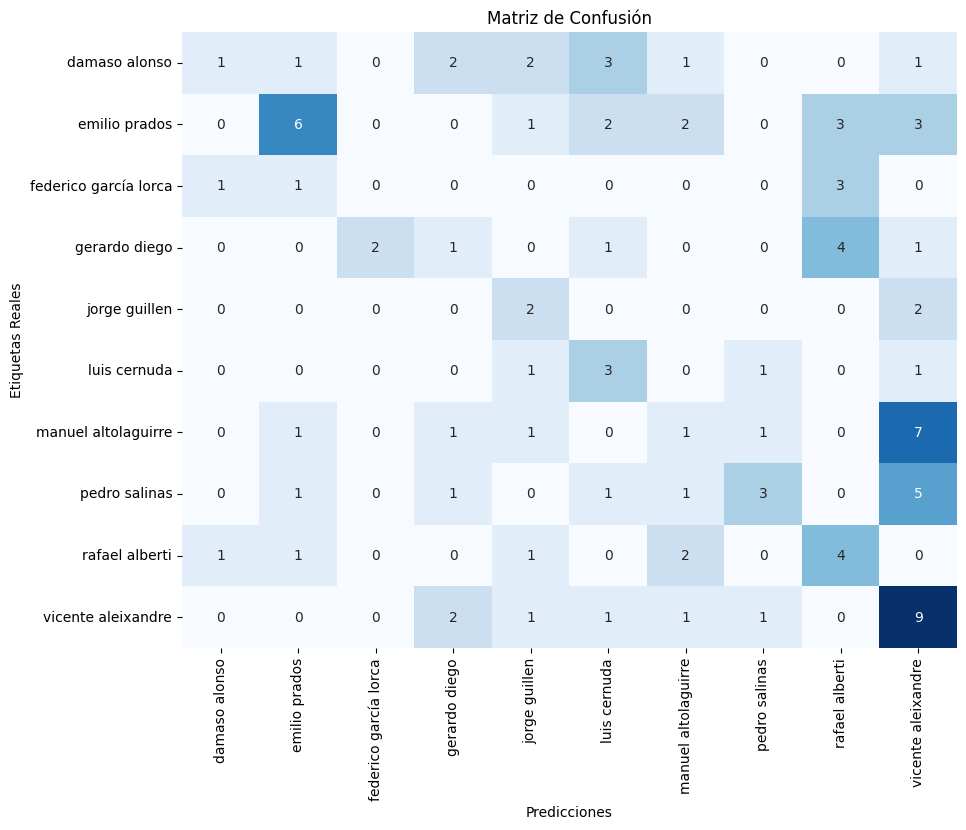

In [20]:
# Calculamos y mostramos métricas adicionales
precision = precision_score(test_labels_encoded, predicted_labels, average='weighted')
recall = recall_score(test_labels_encoded, predicted_labels, average='weighted')
f1 = f1_score(test_labels_encoded, predicted_labels, average='weighted')


print(f'Precisión: {precision:.4f}')
print(f'Recall: {recall:.4f}')
print(f'F1-Score: {f1:.4f}')

# Creamos la matriz de confusión
conf_matrix = confusion_matrix(test_labels_encoded, predicted_labels)

# Visualizamos la matriz de confusión usando seaborn
plt.figure(figsize=(10, 8))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', cbar=False,
            xticklabels=label_encoder.classes_, yticklabels=label_encoder.classes_)
plt.xlabel('Predicciones')
plt.ylabel('Etiquetas Reales')
plt.title('Matriz de Confusión')
plt.show()

# Guardamos el valor de precisión para este modelo en una variable
precision_modelo_RN_2 = accuracy

## MODELO 3: Red neuronal usando selección de autores y solo la columna de texto -poema-

In [21]:
# Filtramos datos solo para los autores específicos
autores_interesantes = ['vicente aleixandre', 'pedro salinas', 'luis cernuda', 'manuel altolaguirre', 'emilio prados']
df_interesantes = df[df['autor'].isin(autores_interesantes)]

# Dividimos los datos en conjuntos de entrenamiento y prueba
train_data, test_data = train_test_split(df_interesantes, test_size=0.2, random_state=42)

# Tokenizamos el texto
tokenizer = Tokenizer()
tokenizer.fit_on_texts(train_data['poema'])

# Convertimos el texto a secuencias de números
X_train = tokenizer.texts_to_sequences(train_data['poema'])
X_test = tokenizer.texts_to_sequences(test_data['poema'])

# Usamos -Pad sequences- para tener la misma longitud en los conjuntos de datos train y test
X_train = pad_sequences(X_train)
X_test = pad_sequences(X_test, maxlen=X_train.shape[1])

# Inicializamos el codificador de etiquetas
label_encoder = LabelEncoder()

# Convertimos las etiquetas de 'autor' a valores numéricos
train_labels_encoded = label_encoder.fit_transform(train_data['autor'])
test_labels_encoded = label_encoder.transform(test_data['autor'])

# Creamos el modelo LSTM mejorado
model = Sequential()
model.add(Embedding(input_dim=len(tokenizer.word_index) + 1, output_dim=200, input_length=X_train.shape[1]))
model.add(LSTM(200, return_sequences=True))
model.add(LSTM(100))
model.add(Dropout(0.2))
model.add(Dense(len(autores_interesantes), activation='softmax'))

# Compilamos el modelo
model.compile(loss='sparse_categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

# Entrenamos el modelo con dropout
model.fit(X_train, train_labels_encoded, epochs=50, validation_split=0.1, batch_size=32)

# Evaluar el modelo en el conjunto de prueba
loss, accuracy = model.evaluate(X_test, test_labels_encoded)
print(f'Precisión del modelo en el conjunto de prueba: {accuracy}')

# Realizamos las predicciones usando el modelo entrenado
predictions = model.predict(X_test)

# Convertimos las predicciones a etiquetas de clase
predicted_labels = np.argmax(predictions, axis=1)

Epoch 1/50
6/6 [==============================] - 26s 3s/step - loss: 1.6121 - accuracy: 0.1611 - val_loss: 1.6039 - val_accuracy: 0.2000
Epoch 2/50
6/6 [==============================] - 23s 4s/step - loss: 1.5790 - accuracy: 0.5333 - val_loss: 1.6085 - val_accuracy: 0.2000
Epoch 3/50
6/6 [==============================] - 19s 3s/step - loss: 1.4202 - accuracy: 0.5833 - val_loss: 1.4331 - val_accuracy: 0.5000
Epoch 4/50
6/6 [==============================] - 17s 3s/step - loss: 1.0557 - accuracy: 0.6722 - val_loss: 1.4118 - val_accuracy: 0.4000
Epoch 5/50
6/6 [==============================] - 17s 3s/step - loss: 0.6792 - accuracy: 0.8722 - val_loss: 1.5039 - val_accuracy: 0.4000
Epoch 6/50
6/6 [==============================] - 19s 3s/step - loss: 0.4154 - accuracy: 0.8889 - val_loss: 1.6486 - val_accuracy: 0.4500
Epoch 7/50
6/6 [==============================] - 18s 3s/step - loss: 0.2366 - accuracy: 0.9722 - val_loss: 1.4864 - val_accuracy: 0.5500
Epoch 8/50
6/6 [==================

Precisión: 0.5213
Recall: 0.4400
F1-Score: 0.4606


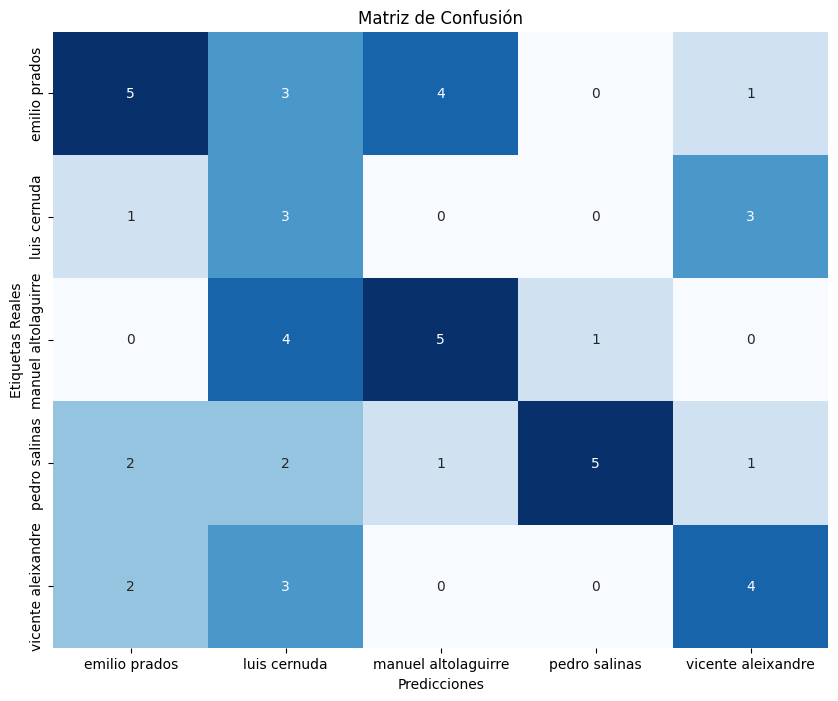

In [22]:
# Calculamos y mostramos métricas adicionales
precision = precision_score(test_labels_encoded, predicted_labels, average='weighted')
recall = recall_score(test_labels_encoded, predicted_labels, average='weighted')
f1 = f1_score(test_labels_encoded, predicted_labels, average='weighted')


print(f'Precisión: {precision:.4f}')
print(f'Recall: {recall:.4f}')
print(f'F1-Score: {f1:.4f}')

# Creamos la matriz de confusión
conf_matrix = confusion_matrix(test_labels_encoded, predicted_labels)

# Visualizamos la matriz de confusión usando seaborn
plt.figure(figsize=(10, 8))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', cbar=False,
            xticklabels=label_encoder.classes_, yticklabels=label_encoder.classes_)
plt.xlabel('Predicciones')
plt.ylabel('Etiquetas Reales')
plt.title('Matriz de Confusión')
plt.show()

# Guardamos el valor de precisión para este modelo en una variable
precision_modelo_RN_3 = accuracy

## MODELO 4: Red neuronal usando selección de autores con estilo literario marcado, variable -poema- y variables auxiliares creadas

In [23]:
# Filtramos datos solo para los autores específicos
autores_interesantes = ['vicente aleixandre', 'pedro salinas', 'luis cernuda', 'manuel altolaguirre', 'emilio prados']
df_interesantes = df[df['autor'].isin(autores_interesantes)]

# Dividimos los datos en conjuntos de entrenamiento y prueba
train_data, test_data = train_test_split(df_interesantes, test_size=0.2, random_state=42)

# Normalizamos las columnas numéricas para evitar distorsiones debidas a los diferentes valores de escala
scaler = MinMaxScaler()
numeric_columns = ['sentimiento', 'numero_total_estrofas', 'entropia_lexica_sust_adj']

train_data[numeric_columns] = scaler.fit_transform(train_data[numeric_columns])
test_data[numeric_columns] = scaler.transform(test_data[numeric_columns])

# Tokenizamos el texto de la variable -poema-
tokenizer = Tokenizer()
tokenizer.fit_on_texts(train_data['poema'])

# Convertimos el texto a secuencias de números
X_train_text = tokenizer.texts_to_sequences(train_data['poema'])
X_test_text = tokenizer.texts_to_sequences(test_data['poema'])

# Aplicamos -Pad sequences- para tener la misma longitud
X_train_text = pad_sequences(X_train_text)
X_test_text = pad_sequences(X_test_text, maxlen=X_train_text.shape[1])

# Inicializamos el codificador de etiquetas
label_encoder = LabelEncoder()

# Convertimos las etiquetas de 'autor' a valores numéricos
train_labels_encoded = label_encoder.fit_transform(train_data['autor'])
test_labels_encoded = label_encoder.transform(test_data['autor'])

# Creamos el modelo LSTM mejorado con características adicionales
input_text = Input(shape=(X_train_text.shape[1],))
embedding_layer = Embedding(input_dim=len(tokenizer.word_index) + 1, output_dim=200, input_length=X_train_text.shape[1])(input_text)
lstm_layer = LSTM(200, return_sequences=True)(embedding_layer)
lstm_layer = LSTM(100)(lstm_layer)
dropout_layer = Dropout(0.2)(lstm_layer)

# Agregamos las columnas numéricas como entrada adicional
input_numeric = Input(shape=(len(numeric_columns),))
concatenated = concatenate([dropout_layer, input_numeric])

dense_layer = Dense(len(autores_interesantes), activation='softmax')(concatenated)

# Creamos el modelo
model = Model(inputs=[input_text, input_numeric], outputs=dense_layer)

# Compilamos el modelo
model.compile(loss='sparse_categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

# Entrenamos el modelo con características adicionales usando los datos del conjunto -train-
model.fit([X_train_text, train_data[numeric_columns]], train_labels_encoded, epochs=50, validation_split=0.1, batch_size=32)

# Evaluamos el modelo en el conjunto de datos de prueba -test-
loss, accuracy = model.evaluate([X_test_text, test_data[numeric_columns]], test_labels_encoded)
print(f'Precisión del modelo en el conjunto de prueba: {accuracy}')

# Realizamos las predicciones usando el modelo entrenado
predictions = model.predict([X_test_text, test_data[numeric_columns]])

# Convertimos las predicciones a etiquetas de clase
predicted_labels = np.argmax(predictions, axis=1)

Epoch 1/50
6/6 [==============================] - 25s 4s/step - loss: 1.6146 - accuracy: 0.1722 - val_loss: 1.6229 - val_accuracy: 0.0500
Epoch 2/50
6/6 [==============================] - 18s 3s/step - loss: 1.5792 - accuracy: 0.4056 - val_loss: 1.6090 - val_accuracy: 0.2500
Epoch 3/50
6/6 [==============================] - 18s 3s/step - loss: 1.5415 - accuracy: 0.5222 - val_loss: 1.5442 - val_accuracy: 0.3500
Epoch 4/50
6/6 [==============================] - 21s 3s/step - loss: 1.1942 - accuracy: 0.6889 - val_loss: 1.5086 - val_accuracy: 0.2500
Epoch 5/50
6/6 [==============================] - 18s 3s/step - loss: 0.8054 - accuracy: 0.7667 - val_loss: 1.7182 - val_accuracy: 0.2500
Epoch 6/50
6/6 [==============================] - 19s 3s/step - loss: 0.5336 - accuracy: 0.8667 - val_loss: 1.5131 - val_accuracy: 0.4500
Epoch 7/50
6/6 [==============================] - 18s 3s/step - loss: 0.3003 - accuracy: 0.9556 - val_loss: 1.5593 - val_accuracy: 0.4500
Epoch 8/50
6/6 [==================

Precisión: 0.5614
Recall: 0.4800
F1-Score: 0.4818


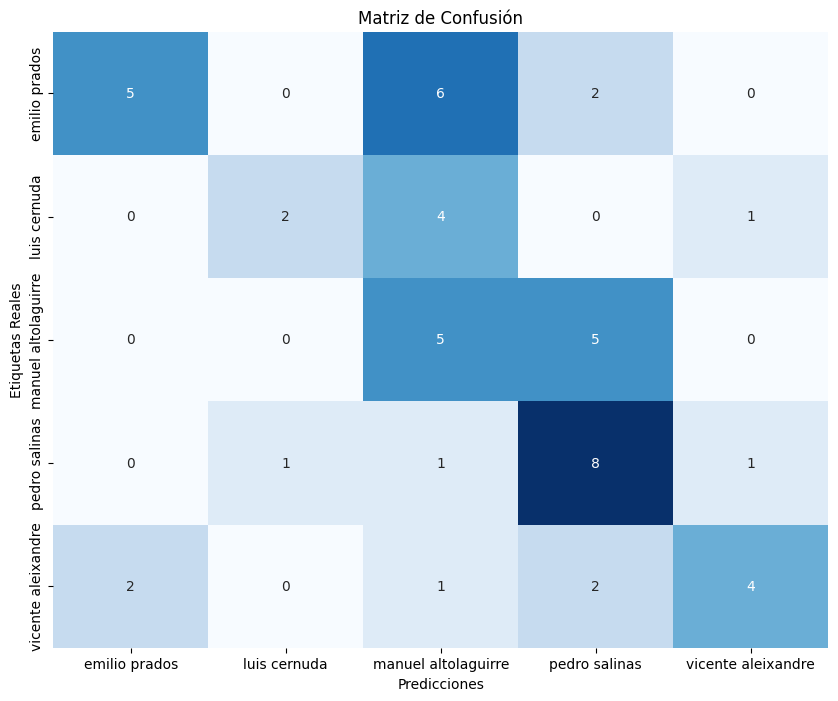

In [24]:
# Calculamos y mostramos métricas adicionales
precision = precision_score(test_labels_encoded, predicted_labels, average='weighted')
recall = recall_score(test_labels_encoded, predicted_labels, average='weighted')
f1 = f1_score(test_labels_encoded, predicted_labels, average='weighted')

print(f'Precisión: {precision:.4f}')
print(f'Recall: {recall:.4f}')
print(f'F1-Score: {f1:.4f}')

# Creamos la matriz de confusión
conf_matrix = confusion_matrix(test_labels_encoded, predicted_labels)

# Visualizamos la matriz de confusión usando seaborn
plt.figure(figsize=(10, 8))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', cbar=False,
            xticklabels=label_encoder.classes_, yticklabels=label_encoder.classes_)
plt.xlabel('Predicciones')
plt.ylabel('Etiquetas Reales')
plt.title('Matriz de Confusión')
plt.show()

# Guardamos el valor de precisión para este modelo en una variable
precision_modelo_RN_4 = accuracy

## MODELO 5: Añadimos al dataframe de análisis la selección de los 5 términos más frecuentes para cada autor en función del método POS y spaCy

In [25]:
# Filtramos datos solo para los autores específicos
autores_interesantes = ['vicente aleixandre', 'pedro salinas', 'luis cernuda', 'manuel altolaguirre', 'emilio prados']
df_interesantes = merged_df[merged_df['autor'].isin(autores_interesantes)]

# Dividimos los datos en conjuntos de entrenamiento y prueba
train_data, test_data = train_test_split(df_interesantes, test_size=0.2, random_state=42)

# Tokenizamos el texto
tokenizer = Tokenizer()
tokenizer.fit_on_texts(train_data['poema'])

# Convertimos el texto a secuencias de números
X_train_text = tokenizer.texts_to_sequences(train_data['poema'])
X_test_text = tokenizer.texts_to_sequences(test_data['poema'])

# Usamos -Pad sequences- sobre los conjuntos de datos para tener la misma longitud
X_train_text = pad_sequences(X_train_text)
X_test_text = pad_sequences(X_test_text, maxlen=X_train_text.shape[1])

# Vectorizamos 'palabras: POS'
vectorizer_palabras_POS = TfidfVectorizer()
X_train_palabras_POS = vectorizer_palabras_POS.fit_transform(train_data['palabras: POS'])
X_test_palabras_POS = vectorizer_palabras_POS.transform(test_data['palabras: POS'])

# Vectorizamos 'palabras: spaCy'
vectorizer_palabras_spacy = TfidfVectorizer()
X_train_palabras_spacy = vectorizer_palabras_spacy.fit_transform(train_data['palabras: spaCy'])
X_test_palabras_spacy = vectorizer_palabras_spacy.transform(test_data['palabras: spaCy'])

# Normalizamos las columnas numéricas
scaler = MinMaxScaler()
numeric_columns = ['sentimiento', 'numero_total_estrofas', 'entropia_lexica_sust_adj']

train_data[numeric_columns] = scaler.fit_transform(train_data[numeric_columns])
test_data[numeric_columns] = scaler.transform(test_data[numeric_columns])

# Combinamos las características vectorizadas y numéricas
X_train_combined = hstack([X_train_text, X_train_palabras_POS, X_train_palabras_spacy, train_data[numeric_columns].values])
X_test_combined = hstack([X_test_text, X_test_palabras_POS, X_test_palabras_spacy, test_data[numeric_columns].values])

# Inicializamos el codificador de etiquetas
label_encoder = LabelEncoder()

# Convertimos las etiquetas de 'autor' a valores numéricos
train_labels_encoded = label_encoder.fit_transform(train_data['autor'])
test_labels_encoded = label_encoder.transform(test_data['autor'])

# Creamos el modelo LSTM mejorado con características adicionales
input_text = Input(shape=(X_train_text.shape[1],))
embedding_layer = Embedding(input_dim=len(tokenizer.word_index) + 1, output_dim=200, input_length=X_train_text.shape[1])(input_text)
lstm_layer = LSTM(200, return_sequences=True)(embedding_layer)
lstm_layer = LSTM(100)(lstm_layer)
dropout_layer = Dropout(0.2)(lstm_layer)

# Agregamos las columnas numéricas como entrada adicional
input_numeric = Input(shape=(len(numeric_columns),))
concatenated = concatenate([dropout_layer, input_numeric])

dense_layer = Dense(len(autores_interesantes), activation='softmax')(concatenated)

# Creamos el modelo
model = Model(inputs=[input_text, input_numeric], outputs=dense_layer)

# Compilamos el modelo
model.compile(loss='sparse_categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

# Entrenamos el modelo con características adicionales
model.fit([X_train_text, train_data[numeric_columns]], train_labels_encoded, epochs=50, validation_split=0.1, batch_size=32)

# Evaluamos el modelo en el conjunto de prueba
loss, accuracy = model.evaluate([X_test_text, test_data[numeric_columns]], test_labels_encoded)
print(f'Precisión del modelo en el conjunto de prueba: {accuracy}')

# Realizamos las predicciones usando el modelo entrenado
predictions = model.predict([X_test_text, test_data[numeric_columns]])

# Convertimos las predicciones a etiquetas de clase
predicted_labels = np.argmax(predictions, axis=1)

Epoch 1/50
6/6 [==============================] - 27s 4s/step - loss: 1.6068 - accuracy: 0.2222 - val_loss: 1.6095 - val_accuracy: 0.2000
Epoch 2/50
6/6 [==============================] - 19s 3s/step - loss: 1.5665 - accuracy: 0.4222 - val_loss: 1.5770 - val_accuracy: 0.4000
Epoch 3/50
6/6 [==============================] - 21s 4s/step - loss: 1.5237 - accuracy: 0.6333 - val_loss: 1.5802 - val_accuracy: 0.2500
Epoch 4/50
6/6 [==============================] - 19s 3s/step - loss: 1.1990 - accuracy: 0.6889 - val_loss: 1.3874 - val_accuracy: 0.3500
Epoch 5/50
6/6 [==============================] - 20s 4s/step - loss: 0.8449 - accuracy: 0.7000 - val_loss: 1.3140 - val_accuracy: 0.4500
Epoch 6/50
6/6 [==============================] - 19s 3s/step - loss: 0.4887 - accuracy: 0.9167 - val_loss: 1.5438 - val_accuracy: 0.3000
Epoch 7/50
6/6 [==============================] - 18s 3s/step - loss: 0.2755 - accuracy: 0.9611 - val_loss: 1.5325 - val_accuracy: 0.4500
Epoch 8/50
6/6 [==================

2/2 [==============================] - 2s 538ms/step


precisión: 0.5654
Recall: 0.5000
F1-Score: 0.5196


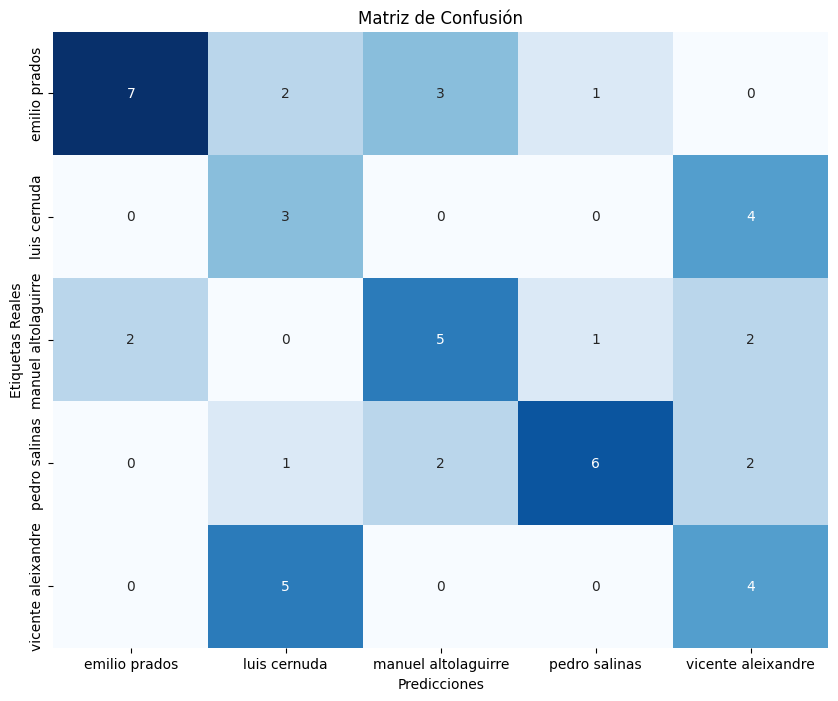

In [26]:
# Calculamos y mostramos métricas adicionales
precision = precision_score(test_labels_encoded, predicted_labels, average='weighted')
recall = recall_score(test_labels_encoded, predicted_labels, average='weighted')
f1 = f1_score(test_labels_encoded, predicted_labels, average='weighted')

print(f'precisión: {precision:.4f}')
print(f'Recall: {recall:.4f}')
print(f'F1-Score: {f1:.4f}')

# Creamos la matriz de confusión
conf_matrix = confusion_matrix(test_labels_encoded, predicted_labels)

# Visualizamos la matriz de confusión usando seaborn
plt.figure(figsize=(10, 8))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', cbar=False,
            xticklabels=label_encoder.classes_, yticklabels=label_encoder.classes_)
plt.xlabel('Predicciones')
plt.ylabel('Etiquetas Reales')
plt.title('Matriz de Confusión')
plt.show()

# Guardamos el valor de precisión para este modelo en una variable
precision_modelo_RN_5 = accuracy

## ANÁLISIS DE RESULTADOS PARA LOS MODELOS DE REDES NEURONALES

In [27]:
# Creamos un DataFrame con la información de las variables que se incluyen en los modelos así como el valor de accuracy obtenido
data = {
    'Modelo': ['Modelo 1 (solo poema)', 'Modelo 2 (poema + variables auxiliares)',
               'Modelo 3 (poema + autores con estilo literario marcado)',
               'Modelo 4 (poema + variables auxiliares + autores con estilo literario marcado)'],
    'Accuracy': [precision_modelo_RN_1, precision_modelo_RN_2, precision_modelo_RN_3, precision_modelo_RN_4]
}

df_accuracy_RN = pd.DataFrame(data)

# Creamos el gráfico de puntos con líneas
fig = px.line(df_accuracy_RN, x='Modelo', y='Accuracy', text='Accuracy', title='Accuracy de los Modelos basados en Redes Neuronales',
             labels={'Accuracy': 'Accuracy del Modelo'})

# Personalizamos el diseño del gráfico
fig.update_traces(mode='markers+lines', marker=dict(color='red', line=dict(color='black', width=2)),
                  textposition='top center', textfont=dict(color='black'))

fig.update_layout(title_text='Accuracy de los modelos de Redes Neuronales',
                  xaxis_title='Modelos', yaxis_title='Accuracy',
                  template='plotly_dark')  # Fondo negro

# Mostramos el gráfico
fig.show()

# ANÁLISIS COMPARATIVO MODELOS DE REGRESIONES Y REDES NEURONALES

In [28]:
# Creamos los dataFrames para los modelos de Redes Neuronales y Regresiones Logísticas y sus valores de accuracy
data_RN = {
    'Modelo': ['Modelo 1 (solo poema)', 'Modelo 2 (poema + variables auxiliares)',
               'Modelo 3 (poema + autores con estilo literario marcado)',
               'Modelo 4 (poema + variables auxiliares + autores con estilo literario marcado)'],
    'Accuracy': [precision_modelo_RN_1, precision_modelo_RN_2, precision_modelo_RN_3, precision_modelo_RN_4]
}

data_RL = {
    'Modelo': ['Modelo 1 (solo poema)', 'Modelo 2 (poema + variables auxiliares)',
               'Modelo 3 (poema + autores con estilo literario marcado)',
               'Modelo 4 (poema + variables auxiliares + autores con estilo literario marcado)'],
    'Accuracy': [accuracy_modelo_log_1, accuracy_modelo_log_2, accuracy_modelo_log_3, accuracy_modelo_log_4]
}

df_accuracy_RN = pd.DataFrame(data_RN)
df_accuracy_RL = pd.DataFrame(data_RL)

# Asignamos nombres diferentes a las columnas del índice temporal
df_accuracy_RN = df_accuracy_RN.rename_axis('Tipo de Modelo').reset_index()
df_accuracy_RL = df_accuracy_RL.rename_axis('Tipo de Modelo').reset_index()

# Creamos el gráfico de dispersión para Redes Neuronales con líneas rojas y puntos amarillos para sus valores
fig_RN = px.scatter(df_accuracy_RN, x='Tipo de Modelo', y='Accuracy', text='Accuracy',
                    title='Comparación de Accuracy entre Modelos de Redes Neuronales',
                    labels={'Accuracy': 'Accuracy del Modelo'})

# Conectamos los valores de accuracy del mismo tipo de modelo con líneas rojas
fig_RN.update_traces(mode='lines+markers', line=dict(shape='linear', width=2, color='red'), marker=dict(color='yellow'))

# Creamos un gráfico de dispersión para Regresiones Logísticas con líneas azules y puntos amarillos para sus valores
fig_RL = px.scatter(df_accuracy_RL, x='Tipo de Modelo', y='Accuracy', text='Accuracy',
                    title='Comparación de Accuracy entre Modelos de Regresiones Logísticas',
                    labels={'Accuracy': 'Accuracy del Modelo'})

# Conectamos los valores de accuracy del mismo tipo de modelo con líneas azules
fig_RL.update_traces(mode='lines+markers', line=dict(shape='linear', width=2, color='blue'), marker=dict(color='yellow'))

# Superponemos los dos gráficos que hemos creado
fig_RN.add_traces(fig_RL.data)

# Ajustamos el diseño del gráfico combinado a la estética de las anteriores visualizaciones
fig_RN.update_layout(title_text='Comparación de Accuracy entre Redes Neuronales y Regresiones Logísticas',
                     xaxis_title='Modelos', yaxis_title='Accuracy',
                     template='plotly_dark')  # Fondo negro

# Mostramos el gráfico combinado
fig_RN.show()
